In [1]:
import pandas as pd
import numpy as np
import collections
from sklearn.linear_model import LogisticRegression

In [2]:
#load dataset
train = pd.read_csv('train.csv',low_memory = False)
#fill empty questions with "no"
train["question1"].fillna("no", inplace = True) 
train["question2"].fillna("no", inplace = True)

In [3]:
#creating dataframe for train data
Total_Data_Frame = pd.DataFrame(train)
Total_Data_Frame = Total_Data_Frame[['id','qid1','qid2','question1','question2','is_duplicate']].copy()
Total_Data_Frame = Total_Data_Frame[:]

In [4]:
#load dataset
test = pd.read_csv('test.csv',low_memory = False)
#fill empty questions with "no"
test["question1"].fillna("no", inplace = True) 
test["question2"].fillna("no", inplace = True)

In [5]:
#creating dataframe for train data
Test_Total_Data_Frame = pd.DataFrame(test)
Test_Total_Data_Frame = Test_Total_Data_Frame[['id','question1','question2']].copy()

In [6]:
# train.describe()

In [7]:
#removing invalid lables
Total_Data_Frame = Total_Data_Frame[(Total_Data_Frame.is_duplicate == '0') | (Total_Data_Frame.is_duplicate == '1')]

In [8]:
# creating dataframe for questions in training set
data_frame = Total_Data_Frame[['question1','question2']].copy()
test_data_frame = Test_Total_Data_Frame[['question1','question2']].copy()

In [9]:
# text processing 
# 1.lower
# 2.remove punctuation
# 3.tokenize
# 4.lemmatising
# 5.remove stop words
# import sys
# reload(sys)
# sys.setdefaultencoding('utf8')
from nltk.corpus import stopwords
import string
from textblob import Word
from nltk.stem.snowball import SnowballStemmer
def preprocessing(d):
        df=d[0]
        df = df.lower()
        #df.translate(None,string.punctuation)
        exclude = set(string.punctuation)
        df = ''.join(ch for ch in df if ch not in exclude)
        list_df=df.split()
        lemmatize_list=[]
        for i in list_df:
            w=Word(i)
            lemmatize_list.append(w.lemmatize())
#         stop_words=set(stopwords.words('english'))
#         filtered_list = [w for w in lemmatize_list if not w in stop_words]
#         filtered_sentence =' '.join(filtered_list)
        filtered_sentence =' '.join(lemmatize_list)
        return filtered_sentence

In [10]:
# df_q1=data_frame[['question1']].copy()
# df_q2=data_frame[['question2']].copy()
# df_q1 = df_q1.apply(preprocessing,axis=1)
# df_q2 = df_q2.apply(preprocessing,axis=1)
# data_frame['question1']=df_q1
# data_frame['question2']=df_q2
# test_df_q1 = test_data_frame[['question1']].copy()
# test_df_q2 = test_data_frame[['question2']].copy()
# test_df_q1 = test_df_q1.apply(preprocessing,axis=1)
# test_df_q2 = test_df_q2.apply(preprocessing,axis=1)
# test_data_frame['question1'] = test_df_q1
# test_data_frame['question2'] = test_df_q2

In [11]:
from collections import Counter

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(data_frame)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

In [12]:
stops = set(stopwords.words("english"))
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

In [13]:
def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
def tf_idf_ngram(d):
    l = [d[0],d[1]]
    vectorizer = TfidfVectorizer(ngram_range = (1,4))
    vectorizer.fit(l)
    question1 = vectorizer.transform([l[0]])
    question2 = vectorizer.transform([l[1]])
    arr1 = question1.toarray()[0]
    arr2 = question2.toarray()[0]
    arr = np.array([arr1,arr2])
    return arr

In [15]:
def cosine_dist(df):
    mat=df[0]
    a = mat[0]
    b = mat[1]
    return np.dot(a,b)

In [16]:
import math
def diff_length(d):
    q1 = d[0]
    q2 = d[1]
    w1 = q1.split()
    w2 = q2.split()
    return abs(len(w1)-len(w2))

In [17]:
def jaccard_similarity(d):
    q1 = d[0]
    q2 = d[1]
    w1 = q1.split()
    w2 = q2.split()
    s1 = set(w1)
    s2 = set(w2)
    return float(len(s1 & s2))/len(s1 | s2)

In [18]:
from fuzzywuzzy import fuzz
def fuzz_features(df):
    q1 = df[0]
    q2 = df[1]
    fuzz_ratio = fuzz.ratio(q1,q2)
    return fuzz_ratio

In [19]:
def bray_curtis_dist(df):
    mat = df[0]
    a = mat[0]
    b = mat[1]
    numerator=sum(abs(x-y) for x,y in zip(a,b))
    denominator=sum((x+y) for x,y in zip(a,b))
    try:
        return float(numerator)/denominator
    except ZeroDivisionError:
        return 1

In [20]:
def euclidian_dist(df):
    mat = df[0]
    a = mat[0]
    b = mat[1]
    return np.linalg.norm(a-b)

In [21]:
# tic0=timeit.default_timer()
train = Total_Data_Frame.copy()
test = Test_Total_Data_Frame.copy()
df1 = train[['question1']].copy()
df2 = train[['question2']].copy()
df1_test = test[['question1']].copy()
df2_test = test[['question2']].copy()

df2.rename(columns = {'question2':'question1'},inplace=True)
df2_test.rename(columns = {'question2':'question1'},inplace=True)

train_questions = df1.append(df2)
train_questions = train_questions.append(df1_test)
train_questions = train_questions.append(df2_test)
train_questions.drop_duplicates(subset = ['question1'],inplace=True)

train_questions.reset_index(inplace=True,drop=True)
questions_dict = pd.Series(train_questions.index.values,index=train_questions.question1.values).to_dict()
train_cp = train.copy()
test_cp = test.copy()
train_cp.drop(['qid1','qid2'],axis=1,inplace=True)

test_cp['is_duplicate'] = -1
test_cp.rename(columns={'test_id':'id'},inplace=True)
comb = pd.concat([train_cp,test_cp])

comb['q1_hash'] = comb['question1'].map(questions_dict)
comb['q2_hash'] = comb['question2'].map(questions_dict)

q1_vc = comb.q1_hash.value_counts().to_dict()
q2_vc = comb.q2_hash.value_counts().to_dict()

def try_apply_dict(x,dict_to_apply):
    try:
        return dict_to_apply[x]
    except KeyError:
        return 0
#map to frequency space
comb['q1_freq'] = comb['q1_hash'].map(lambda x: try_apply_dict(x,q1_vc) + try_apply_dict(x,q2_vc))
comb['q2_freq'] = comb['q2_hash'].map(lambda x: try_apply_dict(x,q1_vc) + try_apply_dict(x,q2_vc))

train_q1_freq = comb[pd.to_numeric(comb['is_duplicate']) >= 0][['q1_freq']]
train_q2_freq = comb[pd.to_numeric(comb['is_duplicate']) >= 0][['q2_freq']]
test_q1_freq = comb[pd.to_numeric(comb['is_duplicate']) < 0][['q1_freq']]
test_q2_freq = comb[pd.to_numeric(comb['is_duplicate'])< 0][['q2_freq']]

In [22]:
tf_idf_ngram_vec = data_frame.apply(tf_idf_ngram,axis=1)
tf_idf_ngram_df = pd.DataFrame(tf_idf_ngram_vec)
tf_idf_ngram_df.rename(columns={ 0 : 'tf_idf_ngram'}, inplace=True)

In [23]:
cosine_dist_ngram_vec = tf_idf_ngram_df.apply(cosine_dist,axis=1)
cosine_dist_ngram_df = pd.DataFrame(cosine_dist_ngram_vec)
rs = cosine_dist_ngram_df.values.reshape(-1,1)
cosine_dist_ngram_df = pd.DataFrame(rs)
#if coisne dist is nan, fill with 0.5 
cosine_dist_ngram_df.fillna(cosine_dist_ngram_df.mean(),inplace=True)
cosine_dist_ngram_vec = cosine_dist_ngram_df[0].tolist()

In [24]:
diff_length_vec = data_frame.apply(diff_length,axis = 1)
diff_length_df = pd.DataFrame(diff_length_vec)
rs = diff_length_df.values.reshape(-1,1)
diff_length_df = pd.DataFrame(rs)
diff_length_df.fillna(diff_length_df.mean(),inplace=True)
diff_length_vec = diff_length_df[0].tolist()

In [25]:
jaccard_similarity_vec = data_frame.apply(jaccard_similarity,axis = 1)
jaccard_similarity_df = pd.DataFrame(jaccard_similarity_vec)
rs = jaccard_similarity_df.values.reshape(-1,1)
jaccard_similarity_df = pd.DataFrame(rs)
jaccard_similarity_df.fillna(jaccard_similarity_df.mean(),inplace=True)
jaccard_similarity_vec = jaccard_similarity_df[0].tolist()

In [26]:
fuzz_features_vec = data_frame.apply(fuzz_features,axis = 1)
fuzz_features_df = pd.DataFrame(fuzz_features_vec)
rs = fuzz_features_df.values.reshape(-1,1)
fuzz_features_df = pd.DataFrame(rs)
fuzz_features_df.fillna(fuzz_features_df.mean(),inplace=True)
fuzz_features_vec = fuzz_features_df[0].tolist()

In [27]:
bray_curtis_dist_vec = tf_idf_ngram_df.apply(bray_curtis_dist, axis=1)
bray_curtis_dist_df = pd.DataFrame(bray_curtis_dist_vec)
rs = bray_curtis_dist_df.values.reshape(-1,1)
bray_curtis_dist_df = pd.DataFrame(rs)
bray_curtis_dist_df.fillna(bray_curtis_dist_df.mean(),inplace=True)
bray_curtis_dist_vec = bray_curtis_dist_df[0].tolist()

In [28]:
euclidian_dist_ngram_vec = tf_idf_ngram_df.apply(euclidian_dist,axis=1)
euclidian_dist_ngram_df = pd.DataFrame(euclidian_dist_ngram_vec)
rs = euclidian_dist_ngram_df.values.reshape(-1,1)
euclidian_dist_ngram_df = pd.DataFrame(rs)
euclidian_dist_ngram_df.fillna(euclidian_dist_ngram_df.mean(),inplace=True)
euclidian_dist_ngram_vec = euclidian_dist_ngram_df[0].tolist()

In [29]:
features_df = pd.DataFrame()
features_df['tfidf_match_score'] = data_frame.apply(tfidf_word_match_share,axis = 1)
features_df['match_score'] = data_frame.apply(word_match_share,axis = 1)
features_df['q1_freq'] = train_q1_freq.copy()
features_df['q2_freq'] = train_q2_freq.copy()
features_df['cosine_dist_ngram'] = cosine_dist_ngram_vec
features_df['diff_length'] = diff_length_vec
features_df['jaccard'] = jaccard_similarity_vec
features_df['fuzz_ratio'] = fuzz_features_vec
features_df['bray_curtis_dist'] = bray_curtis_dist_vec
features_df['euclidian_dist_ngram'] = euclidian_dist_ngram_vec

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


In [30]:
res_df = Total_Data_Frame[['is_duplicate']].copy()
res_df.rename(columns={ 0 : 'is_duplicate'}, inplace=True)
res_vec = res_df.values.ravel()
res_df = pd.DataFrame(res_vec)

In [31]:
#learning rate
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
model = xgb.XGBClassifier()
# learning_rate = [0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1,1.05,1.1,1.15,1.2]
learning_rate = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
param_grid = dict(learning_rate=learning_rate)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)#scikit learn
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
#model and parameters we want to change are passed as parameters cv->Cross Validation
grid_result = grid_search.fit(features_df,res_vec)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.311429 using {'learning_rate': 0.7}


In [32]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

In [33]:
from matplotlib import pyplot
pyplot.errorbar(learning_rate, means, yerr=stds)
pyplot.title("XGBoost learning_rate vs Log Loss")
pyplot.xlabel('learning_rate')
pyplot.ylabel('Log Loss')
pyplot.savefig('learning_rate.png')

In [34]:
import xgboost as xgb
lr = grid_result.best_params_['learning_rate']
model = xgb.XGBClassifier(learning_rate = lr,random_state = 1)
model.fit(features_df,res_vec)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.7, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [35]:
#creating data frame for test data
test_tot_df = pd.DataFrame(Test_Total_Data_Frame)
test_df = test_tot_df[['question1','question2']].copy()

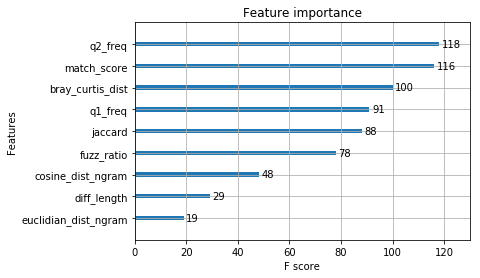

In [36]:
import matplotlib.pyplot as plt
xgb.plot_importance(model)
plt.show()

In [37]:
test_tf_idf_ngram_vec = test_data_frame.apply(tf_idf_ngram,axis=1)
test_tf_idf_ngram_df = pd.DataFrame(test_tf_idf_ngram_vec)
test_tf_idf_ngram_df.rename(columns={ 0 : 'test_tf_idf_ngram'}, inplace=True)

In [38]:
test_cosine_dist_ngram_vec = test_tf_idf_ngram_df.apply(cosine_dist,axis=1)
test_cosine_dist_ngram_df = pd.DataFrame(test_cosine_dist_ngram_vec)
rs = test_cosine_dist_ngram_df.values.reshape(-1,1)
test_cosine_dist_ngram_df = pd.DataFrame(rs)
#if coisne dist is nan, fill with 0.5 
test_cosine_dist_ngram_df.fillna(test_cosine_dist_ngram_df.mean(),inplace=True)
test_cosine_dist_ngram_vec = test_cosine_dist_ngram_df[0].tolist()

In [39]:
test_diff_length_vec = test_data_frame.apply(diff_length,axis = 1)
test_diff_length_df = pd.DataFrame(test_diff_length_vec)
rs = test_diff_length_df.values.reshape(-1,1)
test_diff_length_df = pd.DataFrame(rs)
test_diff_length_df.fillna(test_diff_length_df.mean(),inplace=True)
test_diff_length_vec = test_diff_length_df[0].tolist()

In [40]:
test_jaccard_similarity_vec = test_data_frame.apply(jaccard_similarity,axis = 1)
test_jaccard_similarity_df = pd.DataFrame(test_jaccard_similarity_vec)
rs = test_jaccard_similarity_df.values.reshape(-1,1)
test_jaccard_similarity_df = pd.DataFrame(rs)
test_jaccard_similarity_df.fillna(test_jaccard_similarity_df.mean(),inplace=True)
test_jaccard_similarity_vec = test_jaccard_similarity_df[0].tolist()

In [41]:
test_fuzz_features_vec = test_data_frame.apply(fuzz_features,axis = 1)
test_fuzz_features_df = pd.DataFrame(test_fuzz_features_vec)
rs = test_fuzz_features_df.values.reshape(-1,1)
test_fuzz_features_df = pd.DataFrame(rs)
test_fuzz_features_df.fillna(test_fuzz_features_df.mean(),inplace=True)
test_fuzz_features_vec = test_fuzz_features_df[0].tolist()

In [42]:
test_bray_curtis_dist_vec = test_tf_idf_ngram_df.apply(bray_curtis_dist, axis=1)
test_bray_curtis_dist_df = pd.DataFrame(test_bray_curtis_dist_vec)
rs = test_bray_curtis_dist_df.values.reshape(-1,1)
test_bray_curtis_dist_df = pd.DataFrame(rs)
test_bray_curtis_dist_df.fillna(test_bray_curtis_dist_df.mean(),inplace=True)
test_bray_curtis_dist_vec = test_bray_curtis_dist_df[0].tolist()

In [43]:
test_euclidian_dist_ngram_vec = test_tf_idf_ngram_df.apply(euclidian_dist,axis=1)
test_euclidian_dist_ngram_df = pd.DataFrame(test_euclidian_dist_ngram_vec)
rs = test_euclidian_dist_ngram_df.values.reshape(-1,1)
test_euclidian_dist_ngram_df = pd.DataFrame(rs)
test_euclidian_dist_ngram_df.fillna(test_euclidian_dist_ngram_df.mean(),inplace=True)
test_euclidian_dist_ngram_vec = test_euclidian_dist_ngram_df[0].tolist()

In [44]:
test_features_df = pd.DataFrame()
test_features_df['tfidf_match_score'] = test_data_frame.apply(tfidf_word_match_share,axis = 1)
test_features_df['match_score'] = test_data_frame.apply(word_match_share,axis = 1)
test_features_df['q1_freq'] = test_q1_freq.copy()
test_features_df['q2_freq'] = test_q2_freq.copy()
test_features_df['cosine_dist_ngram'] = test_cosine_dist_ngram_vec
test_features_df['diff_length'] = test_diff_length_vec
test_features_df['jaccard'] = test_jaccard_similarity_vec
test_features_df['fuzz_ratio'] = test_fuzz_features_vec
test_features_df['bray_curtis_dist'] = test_bray_curtis_dist_vec
test_features_df['euclidian_dist_ngram'] = test_euclidian_dist_ngram_vec

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


In [45]:
pred_values_df = Test_Total_Data_Frame[['id']].copy()

In [46]:
pred_values = model.predict_proba(test_features_df)
pred_values_df['is_duplicate'] = pred_values[:,1]

In [48]:
pred_values_df.to_csv("s20.csv",index = False)